# Uber and Lyft's Ride Prices 

**Objective**: To compare the fare between Lyft and Uber & build models to predict fares

**Inspiration**
The aim was to try to analyze the prices of these ride-sharing apps and try to figure out what factors are driving the demand. Do Mondays have more demand than Sunday at 9 am? Do people avoid cabs on a sunny day? Was there a Red Sox match at Fenway that caused more people coming in? 

**Data Summary**  
Source: Kaggle dataset
 
The Cab ride data covers various types of cabs for Uber & Lyft and their price for the given location. You can also find if there was any surge in the price during that time.

Weather data contains weather attributes like temperature, rain, cloud, etc for all the locations taken into consideration.

Time frame: 26th Nov 2018 to 19th Dec 2018 (24 days)  
Location: Boston, MA

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%config Inlinebackground.figureFormat='retina'
sns.set(font_scale=1.75)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
# loading the datasets from text files
# cab data
cab_data = pd.read_csv("D:/2 DS Datasets/New folder/Uber price prediction/cab_rides.csv")
# weather data
weather_data = pd.read_csv("D:/2 DS Datasets/New folder/Uber price prediction/weather.csv")

### Missing Value Treatment

#### Cab Dataset

In [4]:
rows, cols = cab_data.shape
print(f'Cab ride dataset contains {rows} rows and {cols} columns.')

Cab ride dataset contains 693071 rows and 10 columns.


In [5]:
missing  = cab_data.isnull().sum().sum()
percent = round(((missing/cab_data.shape[0]) * 100),2)
print(f'Cab dataset contains {missing} missing values, which is {percent} % of whole data.')

Cab dataset contains 55095 missing values, which is 7.95 % of whole data.


In [6]:
cab_data.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

The missing values are present in the price column. We can convert these rows into validation set or check for reasons for missing data. Let's see if the missing values have some pattern or they occur at random.

In [7]:
# Check on cab type
cab_data[cab_data['price'].isnull()]['cab_type'].value_counts() 

Uber    55095
Name: cab_type, dtype: int64

We can see that, the missing values are present only in the Uber data. Let's also check the car type and model.

In [8]:
cab_data[cab_data['cab_type']=='Uber'].name.value_counts()

UberXL       55096
WAV          55096
Black SUV    55096
Black        55095
Taxi         55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

In [9]:
cab_data[cab_data['price'].isnull()]['name'].value_counts() # car model

Taxi    55095
Name: name, dtype: int64

We see that all missing values belong to cab type = Taxi, Uber official website has no mention of this model and the missing values are less than 10% of the original data, hence we have can drop the records containing missing values.

In [10]:
#dropping the records
cab_data = cab_data.dropna()
rows, cols = cab_data.shape
print(f'Now the dataset contains {rows} rows and {cols} columns.')

Now the dataset contains 637976 rows and 10 columns.


In [11]:
cab_data.isnull().sum().sum() # check for missing values

0

In [12]:
cab_data = cab_data.sample(n=100000) # needs to be reverted at the end
cab_data.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
672481,0.49,Uber,1543408867807,North Station,Haymarket Square,9.5,1.0,57078b3f-05fe-4bef-9a8e-bd8383897b65,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL
471825,1.36,Uber,1544966110823,Beacon Hill,Haymarket Square,27.0,1.0,70efe711-0e33-4db6-b433-6d7c1d1f0162,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV
251420,0.12,Uber,1543358362454,North End,West End,15.0,1.0,7312fcbd-0359-40d4-b291-c0a7f5017e39,6c84fd89-3f11-4782-9b50-97c468b19529,Black


In [13]:
weather_data.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07


**Weather dataset**

In [14]:
rows, cols = weather_data.shape
print(f'weather dataset contains {rows} rows and {cols} columns.')

weather dataset contains 6276 rows and 8 columns.


In [15]:
missing  = weather_data.isnull().sum().sum()
percentage = round(((missing/weather_data.shape[0]) * 100),3)
print(f'weather dataset contains {missing} missing values, which is {percentage} % of whole data.')

weather dataset contains 5382 missing values, which is 85.755 % of whole data.


In [16]:
weather_data.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

We observed that the 'rain' feature has 85.75 % of the data as missing. After checking the weather conditions for that duration we can infer that the missing values are due to unobserved input variable, hence we will impute the missing values with zero, which denotes no rain.

In [17]:
# let's impute the missing values in the 'rain' column with 0
weather_data['rain'].fillna(0, inplace=True)

In [18]:
weather_data.isnull().sum().sum() # check for missing values

0

## Atrribute information

**Dependent variables**:       

    Distance - distance between source and destination             
    Cab_type - Uber or Lyft                 
    Time_stamp - epoch time when data was queried              
    Destination - destination of the ride              
    Source - the starting point of the ride              
    Surge_multiplier - the multiplier by which price was increased, default 1              
    Id - unique identifier              
    Product_id - uber/lyft identifier for cab-type              
    Name - Visible type of the cab eg: Uber Pool, UberXL              

**Target variable**:               

    Price - price estimate for the ride in USD

### Feature category        
**Categorical**       
    - Cab type
    - Destination
    - Source
    - Product Id
    - Name
    - Id
    - Surge Multiplier
    
**Continuous**     
    - Distance
    - Time stamp
    - Price

# Exploratory Data Analysis

In [19]:
# let's impute the time to standard date time format
cab_data['time_stamp'] = pd.to_datetime(cab_data['time_stamp'], unit='ms')
cab_data['date'] = cab_data['time_stamp'].dt.date  # extract date
cab_data['hour'] = cab_data['time_stamp'].dt.hour  # extract hour

cab_data.drop('time_stamp', axis=1, inplace=True)  # drop time_stamp feature

# splitting the dataset for easy access
uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

cab_data.head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
672481,0.49,Uber,North Station,Haymarket Square,9.5,1.0,57078b3f-05fe-4bef-9a8e-bd8383897b65,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-28,12
471825,1.36,Uber,Beacon Hill,Haymarket Square,27.0,1.0,70efe711-0e33-4db6-b433-6d7c1d1f0162,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-16,13
251420,0.12,Uber,North End,West End,15.0,1.0,7312fcbd-0359-40d4-b291-c0a7f5017e39,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-27,22


## Univariate analysis

### Continuous variables

**Distance , Price and Surge Multiplier**

In [20]:
# Uber and Lyft data indexes
all_data=cab_data['cab_type']!=0 
lyft_data=cab_data['cab_type']=='Lyft'
uber_data=cab_data['cab_type']=='Uber'

In [21]:
#function for describing each variable
def col_description(*args,ls):
    for x in args:
        a=cab_data[x].loc[:,ls].apply(lambda x : x.describe(),axis=0)
        print(a)
        print()

In [22]:
num_lst=['distance','price','surge_multiplier']
col_description(all_data,uber_data,lyft_data,ls=num_lst) # gives column description for each dataframe passed

            distance          price  surge_multiplier
count  100000.000000  100000.000000     100000.000000
mean        2.193297      16.574690          1.014970
std         1.139386       9.334584          0.095484
min         0.020000       2.500000          1.000000
25%         1.280000       9.000000          1.000000
50%         2.160000      13.500000          1.000000
75%         2.940000      22.500000          1.000000
max         7.860000      89.000000          3.000000

           distance         price  surge_multiplier
count  51864.000000  51864.000000           51864.0
mean       2.190511     15.825409               1.0
std        1.182078      8.573517               0.0
min        0.020000      4.500000               1.0
25%        1.300000      9.000000               1.0
50%        2.170000     12.500000               1.0
75%        2.840000     21.500000               1.0
max        7.860000     73.500000               1.0

           distance         price  surge_mul

In [23]:
cat_lst=['destination','source','name'] # dropped factor variables which were not useful
col_description(all_data,uber_data,lyft_data,ls=cat_lst) # gives column description for each dataframe passed

               destination             source       name
count               100000             100000     100000
unique                  12                 12         12
top     Financial District  Boston University  Black SUV
freq                  8727               8495       8752

               destination                   source       name
count                51864                    51864      51864
unique                  12                       12          6
top     Financial District  Northeastern University  Black SUV
freq                  4464                     4446       8752

               destination             source   name
count                48136              48136  48136
unique                  12                 12      6
top     Financial District  Boston University   Lyft
freq                  4263               4096   8170



In [24]:
# function to perform basic EDA for input columns
def EDA_function(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.distplot(df[lyft_data], ax=ax1, kde=True)
    ax1.set_title('Distribution of '+df.name+' in Lyft', fontsize=20)
    sns.distplot(df[uber_data], ax=ax2)
    ax2.set_title('Distribution of '+df.name+' in Uber', fontsize=20)
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    sns.boxplot(df[lyft_data], ax=ax1)
    ax1.set_title('Boxplot for '+df.name+' in Lyft', fontsize=20)
    sns.boxplot(df[uber_data], ax=ax2)
    ax2.set_title('Boxplot for '+df.name+' in Uber', fontsize=20)
    return(1)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-

distance            1
price               1
surge_multiplier    1
dtype: int64

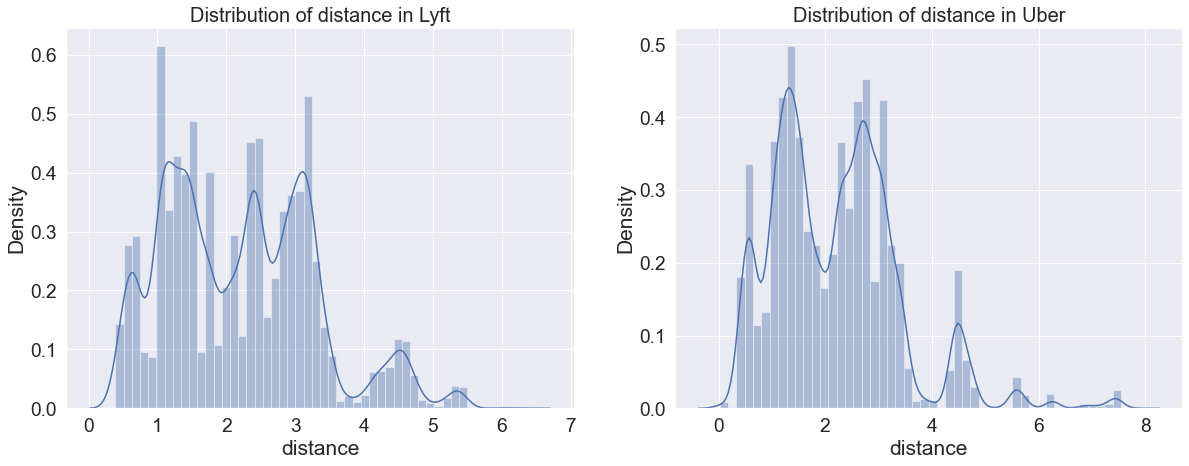

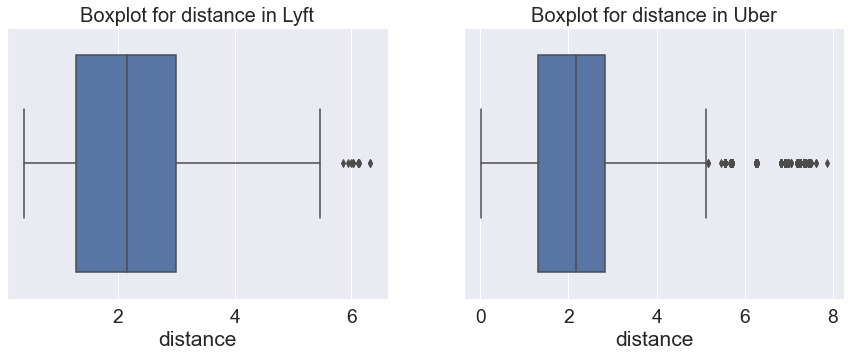

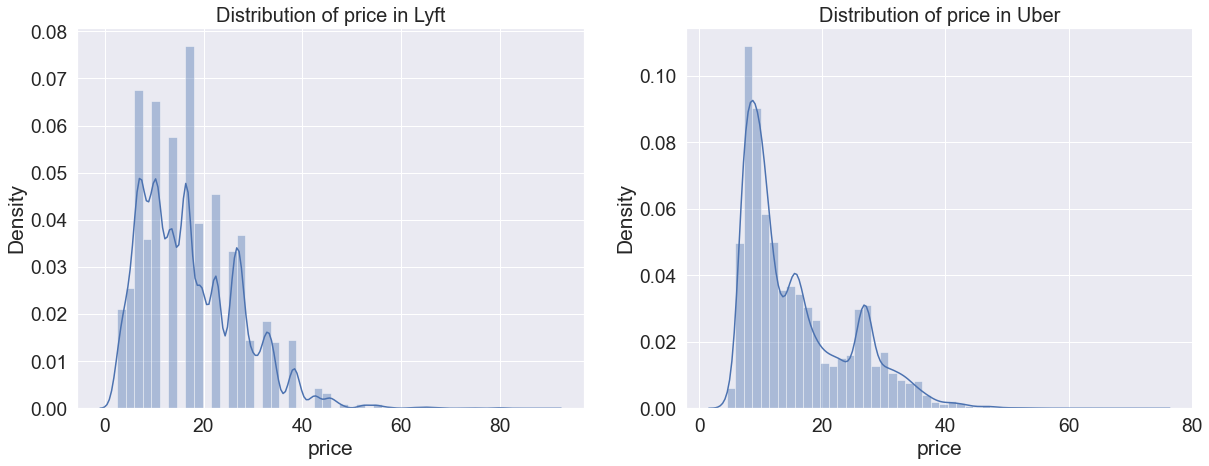

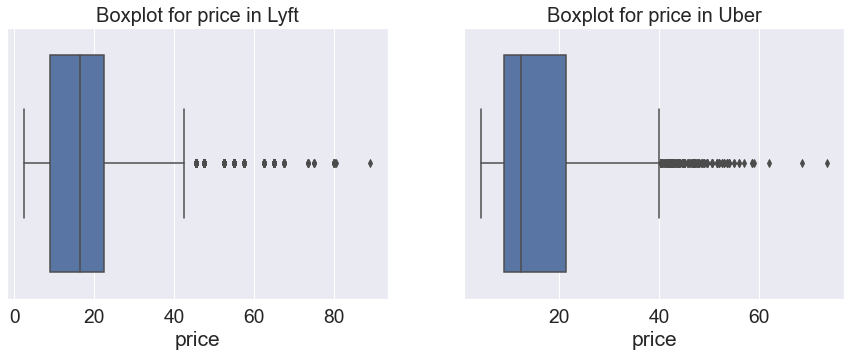

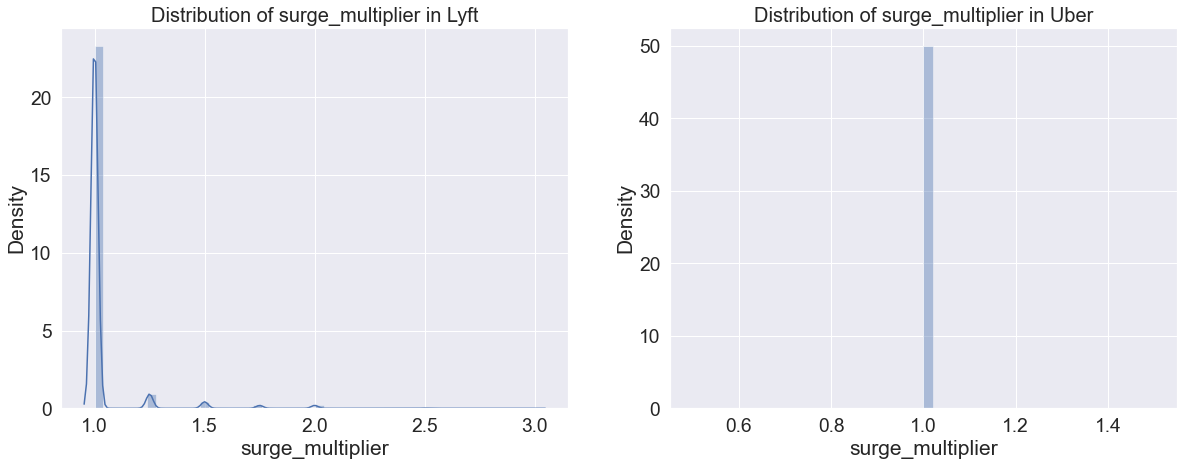

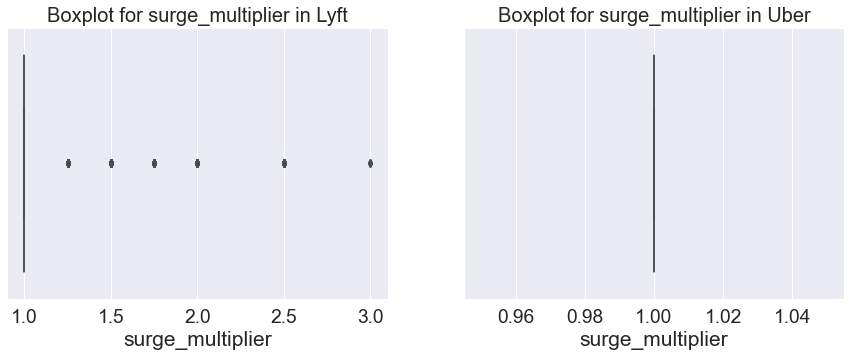

In [25]:
cab_data.loc[:,['distance','price','surge_multiplier']].apply(EDA_function,axis=0)
#cab_data.loc[:,['price']].apply(EDA_function,axis=0)

In [26]:
# Remove records below 0.25 as cancellation records
lyft[lyft['distance']<0.25] 

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour


In [27]:
uber[uber['distance']<0.25].sort_values(by='distance', ascending=False).head(5)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
165948,0.17,Uber,Theatre District,Boston University,16.0,1.0,530cc008-5065-4d3d-b672-247e36aa7a0e,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03,8
275835,0.17,Uber,Theatre District,Boston University,4.5,1.0,7857e0d0-14eb-4c42-9099-9252e821f80d,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-12-15,7
251420,0.12,Uber,North End,West End,15.0,1.0,7312fcbd-0359-40d4-b291-c0a7f5017e39,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-27,22
513652,0.12,Uber,North End,West End,15.0,1.0,bd98bc78-f693-41fe-800d-c496cbe09cde,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-13,11
582921,0.12,Uber,North End,West End,8.5,1.0,311d53fc-c29d-4d18-9bf3-d8714664f20d,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-29,12


In [28]:
cab_data=cab_data[cab_data['distance']>=0.25]
uber=uber[uber['distance']>=0.25]
lyft=lyft[lyft['distance']>=0.25] 

From the above graphs, we can see that most of the rides are in the range of approximately 0.5 to 5.5 miles. 
The distribution is slightly right skewed in the both Lyft and Uber.
Distance in Lyft is more evenly dispersed than Uber.

**Outliers**       
Both the data contains some outliers, this may be due to weather conditions in which riders may have to travel extra distance than usual or occassionally riders tend to travel long distances. Outliers couldalso be due to use of high-end cars and high surge multipliers. Therefore, we decided to keep them.

In [29]:
lyft[(lyft['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
635779,2.30,Lyft,Boston University,Beacon Hill,47.5,1.50,4444355f-a2f6-467f-8b3b-7e1c737198a9,lyft_luxsuv,Lux Black XL,2018-12-01,22
164763,3.42,Lyft,North Station,Boston University,42.5,1.00,e28ca551-e26d-45a5-b0d8-bba6231b73c8,lyft_luxsuv,Lux Black XL,2018-12-15,18
534106,2.39,Lyft,Back Bay,South Station,47.5,1.25,e27a5059-9b50-41fe-a62a-ded2d7e8485d,lyft_luxsuv,Lux Black XL,2018-11-28,21


In [30]:
uber[(uber['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
618458,3.30,Uber,Northeastern University,Financial District,42.0,1.0,d521c586-b3d7-486e-b74c-3053d3116d2f,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-29,23
281247,7.46,Uber,Northeastern University,Financial District,42.0,1.0,95c8b370-7e0d-451b-b1b5-23a02bfa1ecf,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-13,7
343531,5.56,Uber,Boston University,Financial District,47.0,1.0,58848fa2-b374-496a-8cf8-e8fcaaa93aec,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-17,0


**Outliers handling**      
We could see that, some rides are higher priced than usual for different car models. From our analysis, we can conclude that duration of the trip also has an impact on the price, and we do not posses data regarding the duration of the trip, so we cannot remove these outliers.

The price distribution is right skewed, from the boxplot we could see the outliers present in the data. On average, the price range varies from 5 to 40 US dollars, Outliers exists due to factors such as use of luxury cars, high city traffic and bad weather conditions.

**Categorical variables**

**Cab type**

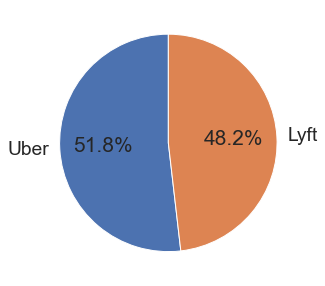

In [31]:
plt.figure(figsize=(8,5))

#Pie
Ncab_type = [cab_data.cab_type[(cab_data.cab_type)=='Uber'].count(),\
             cab_data.cab_type[(cab_data.cab_type)=='Lyft'].count()]
     
cab_type = ['Uber','Lyft']
plt.pie(Ncab_type, labels=cab_type, startangle=90, autopct='%.1f%%')
plt.show()

The dataset contains relatively higher proportion of Uber data, but we can say overall it is still balanced.

**Source, Destination and Name**

In [32]:
# function to perform basic EDA for input categorical variables
def EDA_cat_function(df):
    plt.figure(figsize=(8,5))
    sns.countplot(df[lyft_data])
    plt.title('Overall Frequency of '+df.name, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.countplot(df[lyft_data], ax=ax1)
    ax1.set_title('Frequency of '+df.name+' in Lyft', fontsize=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
    
    sns.countplot(df[uber_data], ax=ax2)
    ax2.set_title('Frequency of '+df.name+' in Uber', fontsize=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)
    return(1)

From the charts below, we see that, there is a variety of surge mulipliers in Lyft, whereas in Uber, there is only one surge multiplier. This can be a possible reason for increased number of riders in Uber, compared to Lyft. From the frequency plot, we could see that almost all the car models are used in similar frequency.

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: Futur

destination    1
source         1
name           1
dtype: int64

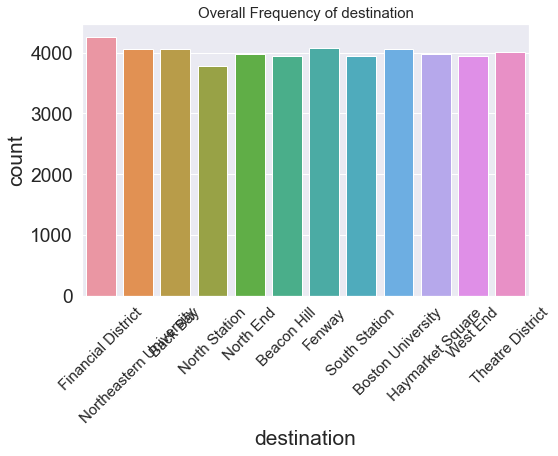

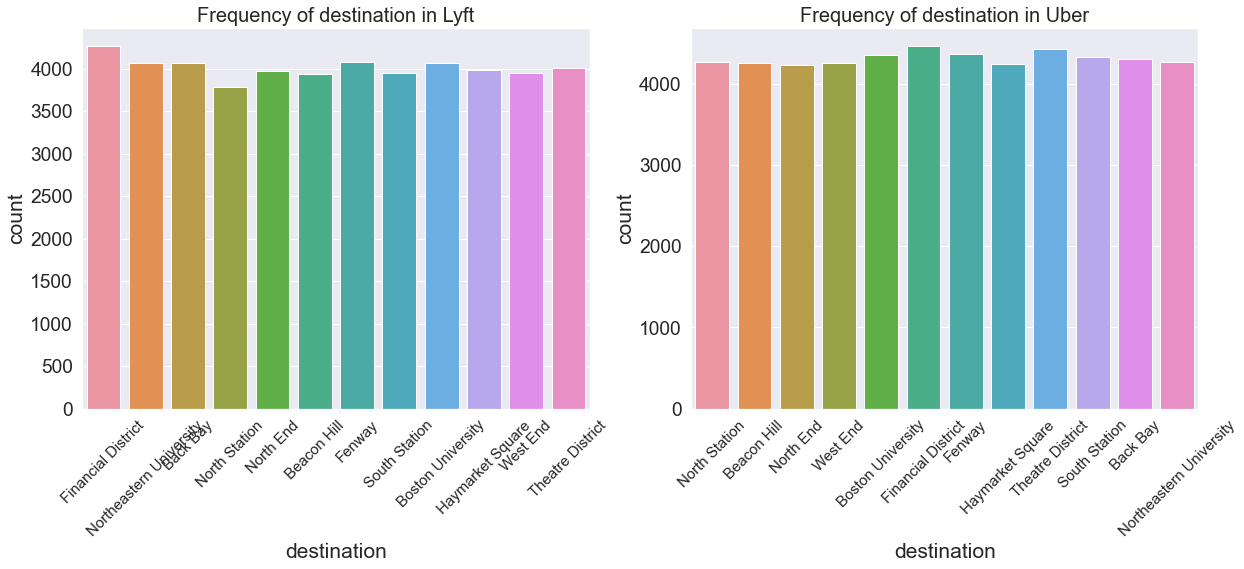

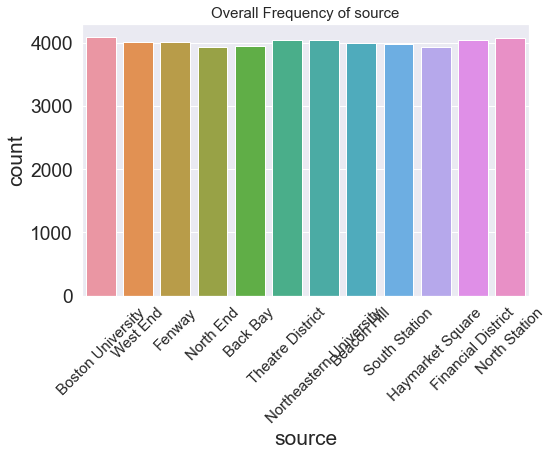

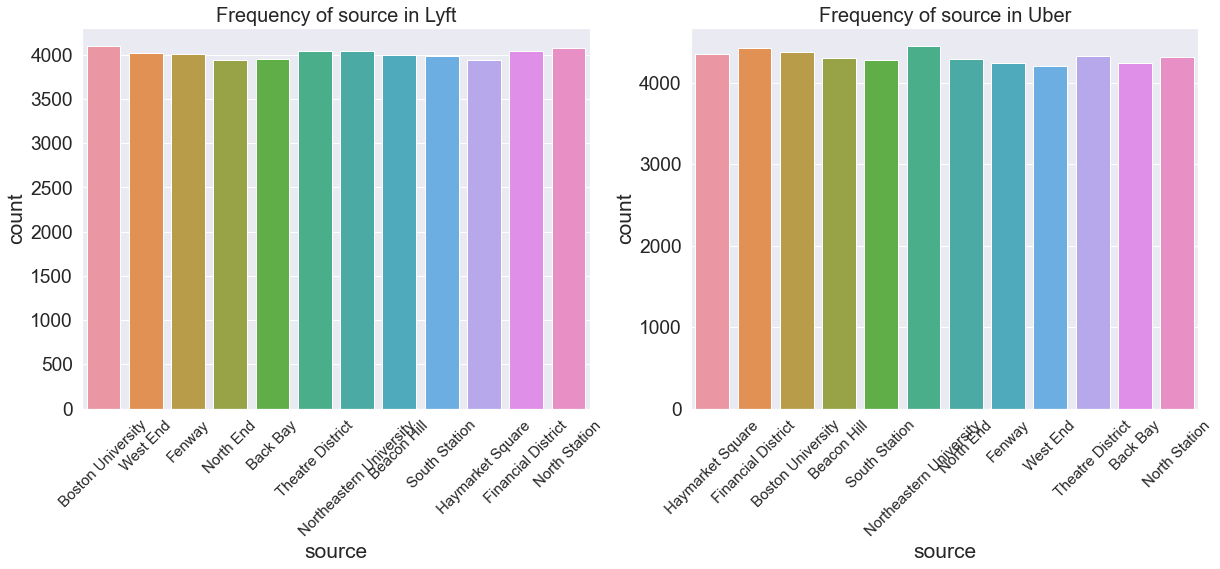

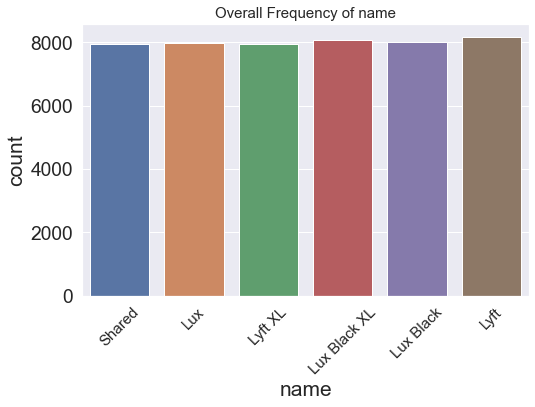

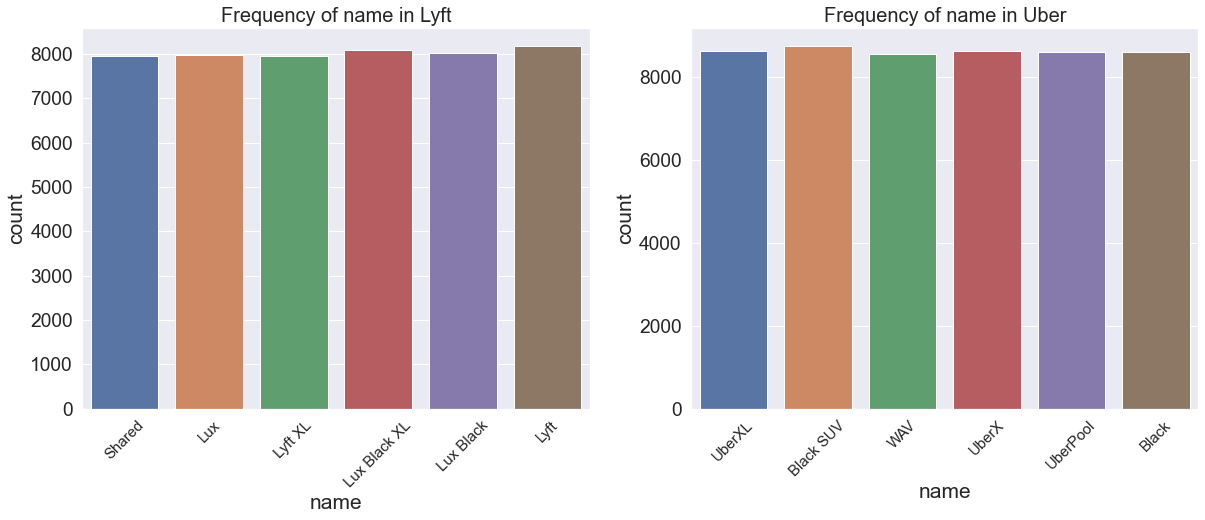

In [33]:
cab_data.loc[:,['destination','source','name']].apply(EDA_cat_function,axis=0)

## Price Vs Distance Analysis

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8328\2245800229.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

(0.0, 100.0)

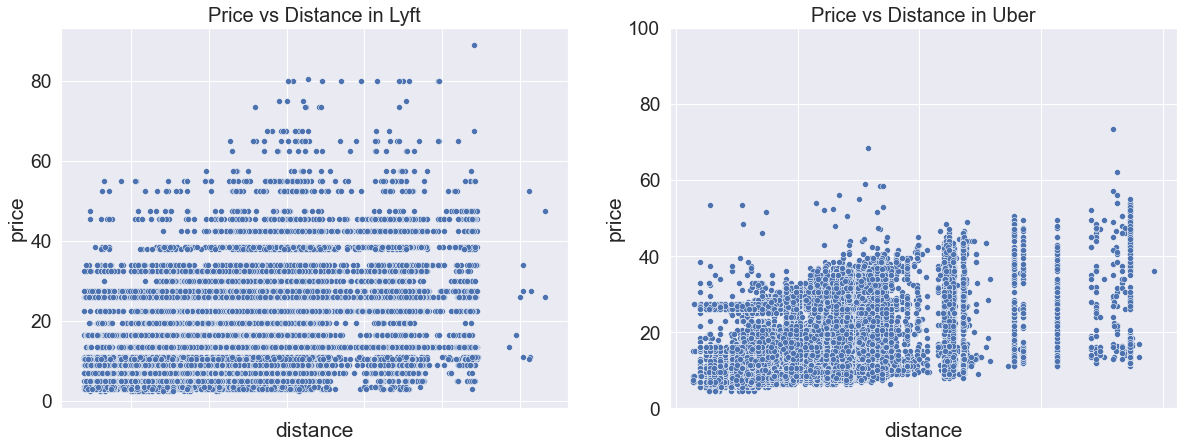

In [34]:
# scatterplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(lyft['distance'], lyft['price'], ax=ax1)
ax1.set_title('Price vs Distance in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(uber['distance'], uber['price'], ax=ax2)
ax2.set_title('Price vs Distance in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 100)

In [35]:
lyft['distance'].corr(lyft['price'])

0.3632667376417643

In [36]:
uber['distance'].corr(uber['price'])

0.33369880654187567

Distance is one of the important factors, which drives the price of the rides.  We could see that there is a positive 
correlation in the graph, with the presence of outliers as we saw before, because of the use of luxury car models and 
bad weather conditions.

### Data Tables  - Get better sense of the data

**Cab type vs Surge multiplier**

In [37]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'])

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
cab_type,,,,,,,
Lyft,44863,1744,796,350,353,25,5
Uber,51795,0,0,0,0,0,0


We observe that surge multiplier is not available for uber data and only present in Lyft data.

**Car model vs Surge multiplier**

In [38]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'])

surge_multiplier,1.00,1.25,1.50,1.75,2.00,2.50,3.00
name,,,,,,,
Lux,7331,331,155,68,85,0,0
Lux Black,7326,363,174,71,79,0,0
Lux Black XL,7424,357,164,74,61,0,0
Lyft,7497,349,167,73,67,15,2
Lyft XL,7335,344,136,64,61,10,3
Shared,7950,0,0,0,0,0,0


## Weather dataset

In [39]:
weather_data.info() # basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        6276 non-null   float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


**Attribute Information**

Location - Location name              
Clouds              
Pressure - pressure in mb              
Rain - rain in inches for the last hr              
Time_stamp - epoch time when row data was collected              
Humidity - humidity in %              
Wind - wind speed in mph

### Feature category        
**Categorical**       
    - location
    
**Continuous**     
    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

### Univariate Analysis

In [40]:
# let's impute the time to standard date time format
weather_data['time_stamp'] = pd.to_datetime(weather_data['time_stamp'], unit='s')
weather_data['date'] = weather_data['time_stamp'].dt.date
weather_data['hour'] = weather_data['time_stamp'].dt.hour

weather_data.drop('time_stamp', axis=1, inplace=True)

In [41]:
weather_data.head(2)

,temp,location,clouds,pressure,rain,humidity,wind,date,hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16,23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16,23


### Continuous

**Temperature , Cloud, Pressure, Rain , Humidity and Wind**

In [42]:
num_lst=['temp','clouds','pressure','rain','humidity','wind']
weather_data.loc[:,num_lst].apply(lambda x : x.describe(),axis=0)

,temp,clouds,pressure,rain,humidity,wind
count,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.008212,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.043021,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000000,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.000000,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.000000,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.000000,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,0.990000,18.180000


In [43]:
cat_lst=['location']
weather_data.loc[:,cat_lst].apply(lambda x : x.describe(),axis=0)

,location
count,6276
unique,12
top,Back Bay
freq,523


In [44]:
# function to perform basic EDA for input columns
def EDA_weather(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.distplot(df[~df.isnull()], ax=ax1, kde=True)
    ax1.set_title('Distribution of '+df.name, fontsize=20)
    sns.boxplot(df[~df.isnull()], ax=ax2)
    ax2.set_title('Boxplot for '+df.name, fontsize=20)
    return(1)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\

temp        1
clouds      1
pressure    1
rain        1
humidity    1
wind        1
dtype: int64

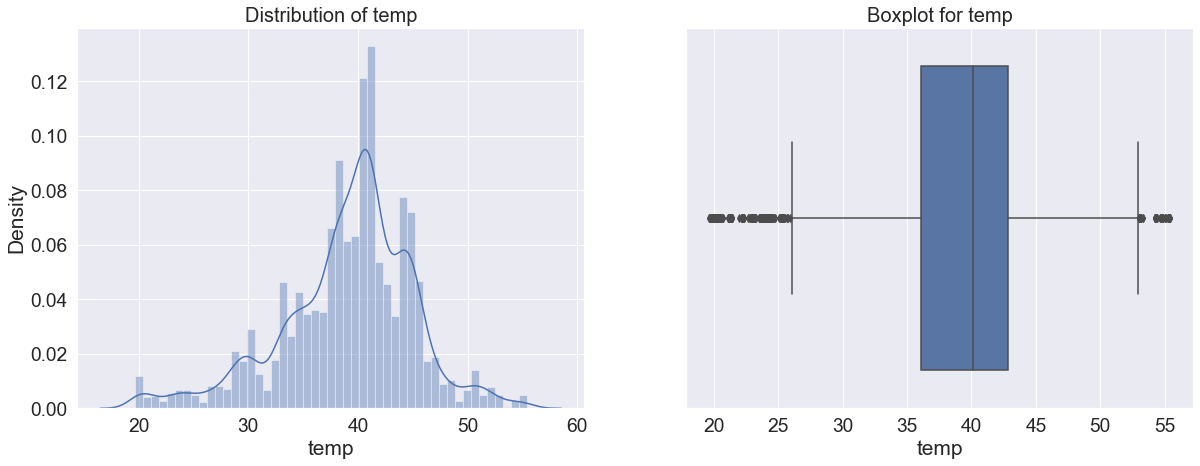

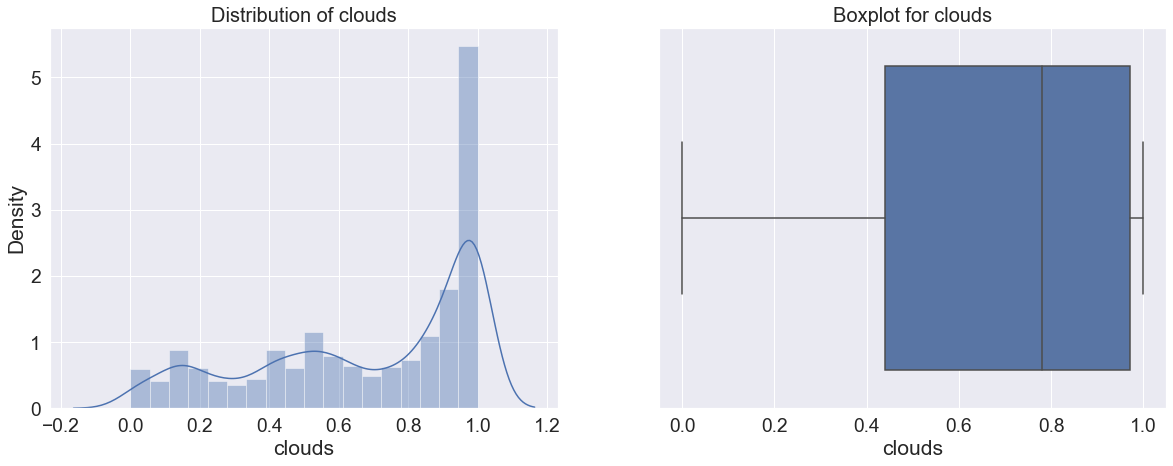

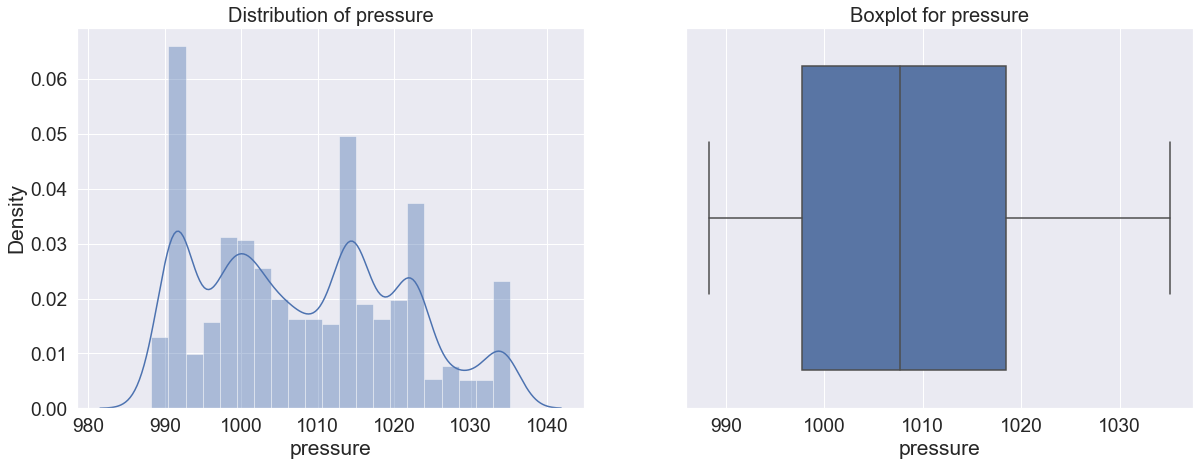

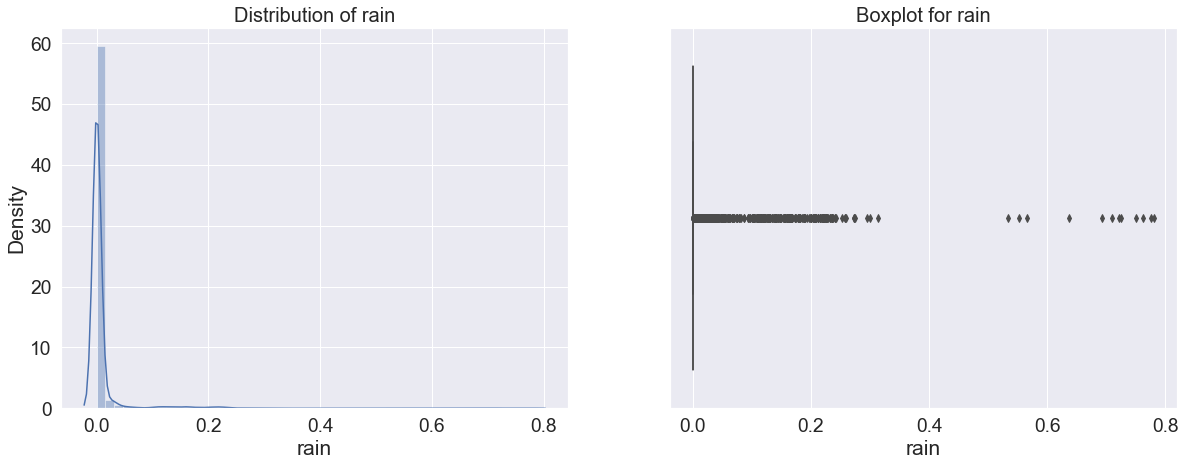

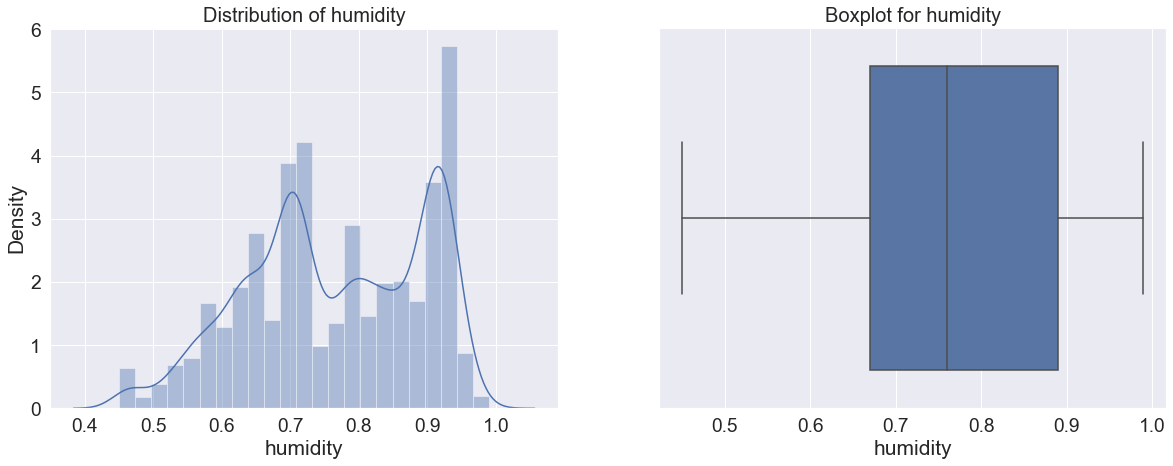

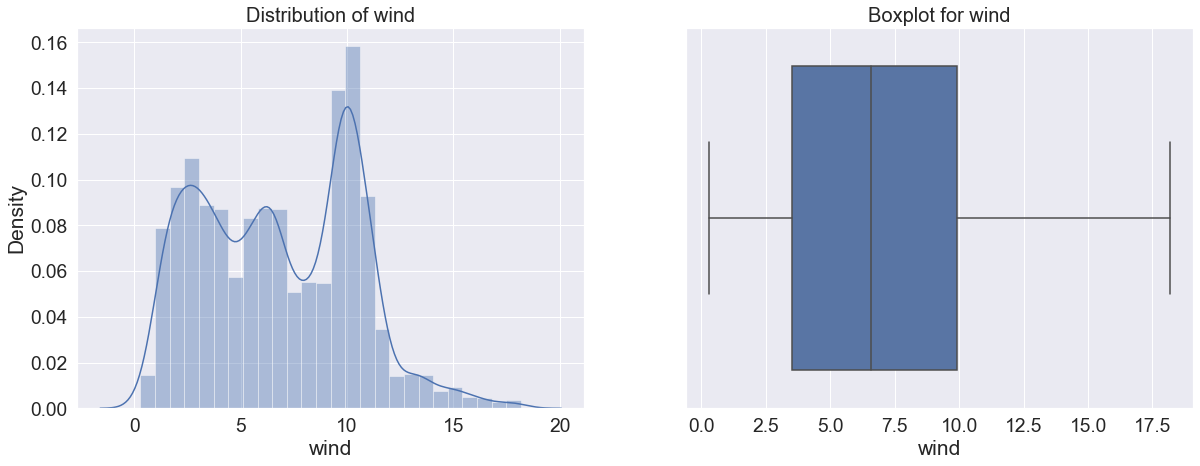

In [45]:
weather_data.loc[:,['temp','clouds','pressure','rain','humidity','wind']].apply(EDA_weather,axis=0)

In [46]:
weather_data[weather_data.temp < 26].date.value_counts()

2018-12-13    171
2018-12-18     48
Name: date, dtype: int64

In [47]:
weather_data[weather_data.temp > 53].date.value_counts()

2018-12-03    43
Name: date, dtype: int64

According to this website https://www.timeanddate.com/weather/usa/boston/historic?month=12&year=2018,
the data is legitimate. We can keep the outliers.

Temperature is slighty left skewed, and it makes sense, because this data is collected around the month of november,
although occassionally we can see high temperature as well in locations such as Financial district, Boston university
and Back bay.

In [48]:
weather_data[weather_data['rain']>0].date.value_counts()

2018-11-27    380
2018-12-02    137
2018-11-26    126
2018-12-17     75
2018-12-16     65
2018-11-29     42
2018-12-03     24
2018-11-28     23
2018-12-18     12
2018-12-01      9
2018-12-15      1
Name: date, dtype: int64

**Outliers handling**

Rain is right skewed, it is understandable as this data is collected for 17 days, only in few days, there was rain
in Boston city. So, we've decided not to remove these outliers.

### Bi-variate analysis

    - temp
    - time stamp
    - clouds
    - pressure
    - rain
    - humidity
    - wind

**Continuous & Continuous**

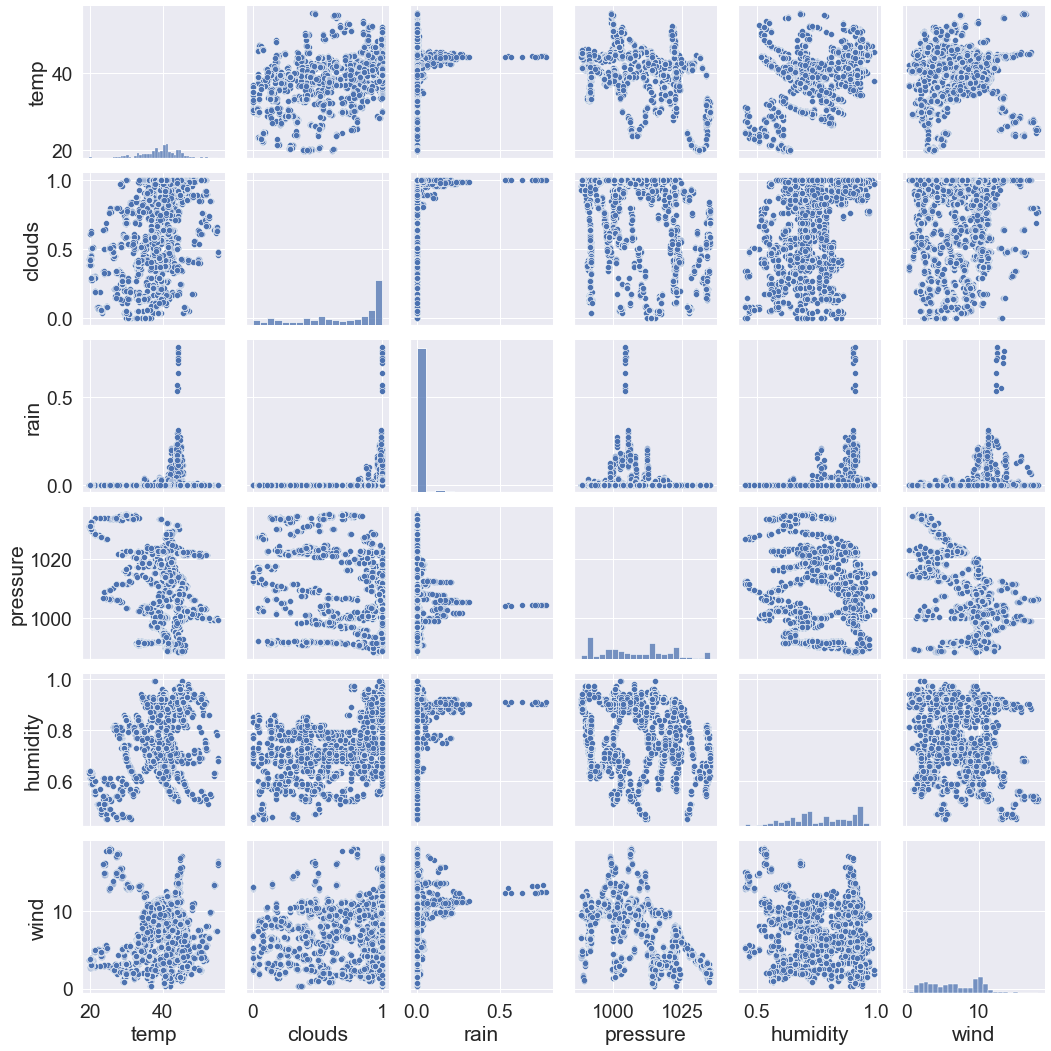

In [49]:
sns.pairplot(weather_data[['temp', 'clouds', 'rain', 'pressure', 'humidity', 'wind']])

**Categorical & Continuous**

In [50]:
def box_func(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df, y=weather_data['location'], orient='h')
    plt.title('Boxplot for location Vs '+df.name, fontsize=15)
    return(1)

temp        1
clouds      1
pressure    1
rain        1
humidity    1
wind        1
dtype: int64

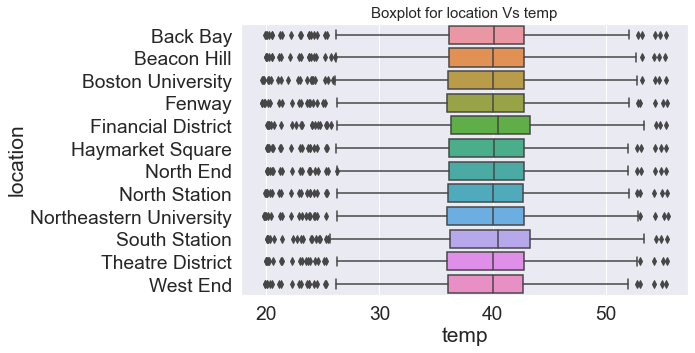

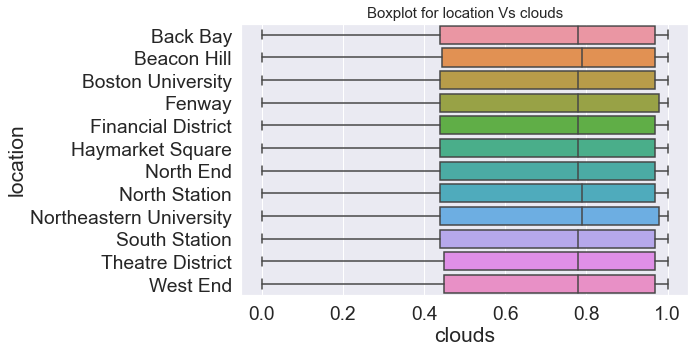

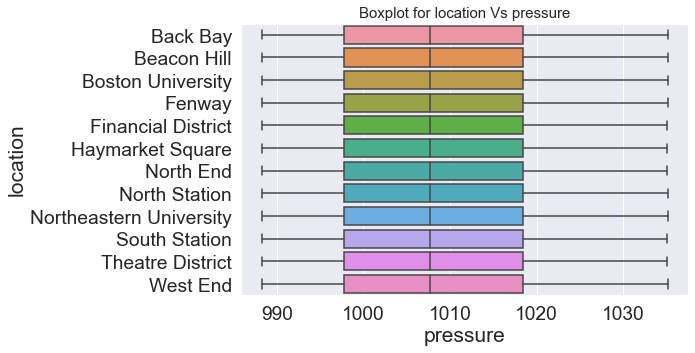

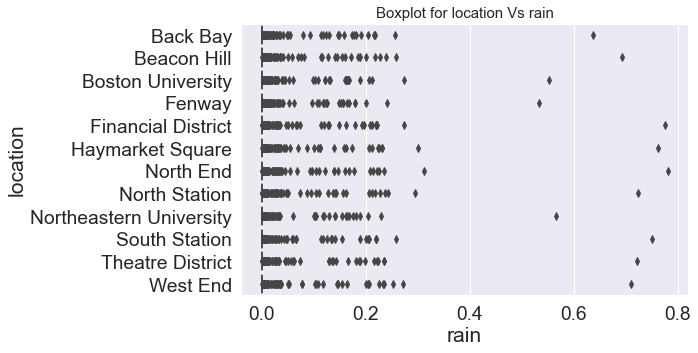

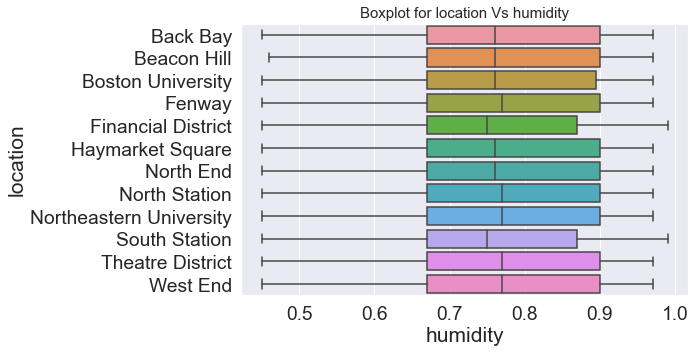

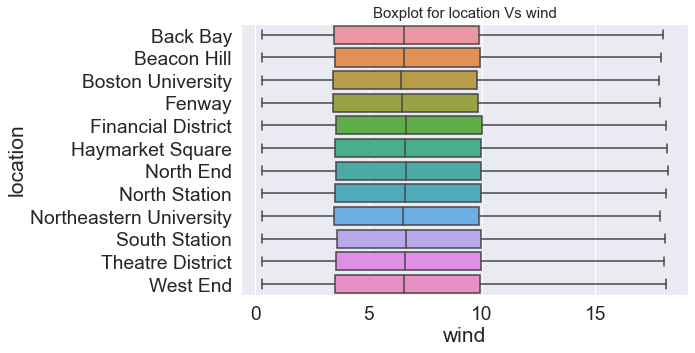

In [51]:
weather_data.loc[:,['temp','clouds','pressure','rain','humidity','wind']].apply(box_func,axis=0)

Since the data is collected within Boston city, the rain has effect on all the locations within the city,
among those locations such as Financial District, Haymarket Square and North end have experienced high rainfall.

### Model Preparation

In [52]:
# weather data supposed to contain 1 record per hour, since it has more than one values for few hours, 
# we took groupby average
weather_data = weather_data.groupby(['location','date', 'hour']).mean()
weather_data.reset_index(inplace=True)

In [53]:
#joining 2 datasets together
merged_data = pd.merge(cab_data, weather_data, how='left', left_on=['source', 'date', 'hour'],
        right_on=['location', 'date', 'hour'])

In [54]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99931 entries, 0 to 99930
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          99931 non-null  float64
 1   cab_type          99931 non-null  object 
 2   destination       99931 non-null  object 
 3   source            99931 non-null  object 
 4   price             99931 non-null  float64
 5   surge_multiplier  99931 non-null  float64
 6   id                99931 non-null  object 
 7   product_id        99931 non-null  object 
 8   name              99931 non-null  object 
 9   date              99931 non-null  object 
 10  hour              99931 non-null  int64  
 11  location          99543 non-null  object 
 12  temp              99543 non-null  float64
 13  clouds            99543 non-null  float64
 14  pressure          99543 non-null  float64
 15  rain              99543 non-null  float64
 16  humidity          99543 non-null  float6

We could see that there is null values in the data.

In [55]:
merged_data[merged_data.temp.isnull()].groupby(['source', 'date', 'hour']).mean().head(6)

distance      price  surge_multiplier  temp  \
source      date       hour                                                
Back Bay    2018-11-28 1     2.231429  16.357143          1.107143   NaN   
            2018-12-04 6     1.649412  13.323529          1.000000   NaN   
            2018-12-18 19    2.262000  20.500000          1.050000   NaN   
Beacon Hill 2018-11-28 1     2.098571  15.571429          1.000000   NaN   
            2018-12-04 6     1.714000  13.300000          1.000000   NaN   
            2018-12-18 19    2.090000  20.375000          1.000000   NaN   

                             clouds  pressure  rain  humidity  wind  
source      date       hour                                          
Back Bay    2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN  
Beacon Hill 2018-11-28 1        NaN       NaN   NaN       NaN   NaN  
            2018-12-04 6        NaN       NaN   NaN       NaN   NaN  
            2018-12-18 19       NaN       NaN   NaN       NaN   NaN

Weather data doesn't have records for this particular dates and hours, let's impute these values with the previous values.

In [56]:
df1 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==0)]

df2 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==5)]
df3 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 11, 28)) &
    (weather_data['hour']==2)]
df4 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 4)) &
    (weather_data['hour']==7)]


lookup = pd.concat([df1, df2, df3, df4])
lookup = lookup.groupby(['hour', 'location', 'date']).mean().reset_index()
df5 = weather_data.loc[
    (weather_data['date']==datetime.date(2018, 12, 18)) &
    (weather_data['hour']==18)]

lookup = pd.concat([lookup, df5])
lookup['hour'] += 1
lookup.reset_index(inplace=True)

In [57]:
weather_data = pd.concat([weather_data, lookup], ignore_index=True) 

In [58]:
cab_data = pd.merge(cab_data, weather_data, how='left',
                left_on=['source', 'date', 'hour'],
                right_on=['location', 'date', 'hour'])

In [59]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99931 entries, 0 to 99930
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          99931 non-null  float64
 1   cab_type          99931 non-null  object 
 2   destination       99931 non-null  object 
 3   source            99931 non-null  object 
 4   price             99931 non-null  float64
 5   surge_multiplier  99931 non-null  float64
 6   id                99931 non-null  object 
 7   product_id        99931 non-null  object 
 8   name              99931 non-null  object 
 9   date              99931 non-null  object 
 10  hour              99931 non-null  int64  
 11  location          99931 non-null  object 
 12  temp              99931 non-null  float64
 13  clouds            99931 non-null  float64
 14  pressure          99931 non-null  float64
 15  rain              99931 non-null  float64
 16  humidity          99931 non-null  float6

In [60]:
cab_data.drop('index', axis=1, inplace=True)

In [61]:
cab_data.shape, cab_data.drop_duplicates().shape

((99931, 18), (99931, 18))

In [62]:
# drop unnecessary features
cab_data = cab_data.drop(['id', 'product_id', 'location', 'date'], axis=1)

In [63]:
# Initial data preparation
data = cab_data.drop(['price', 'surge_multiplier'], axis=1) # we are dropping surge multiplier, to avoid data leak
labels = cab_data['price'].copy()

In [64]:
# model building libraries

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [65]:
uber = cab_data[cab_data['cab_type']=='Uber']
uber.reset_index(inplace=True)
uber.drop('index', axis=1, inplace=True)
lyft = cab_data[cab_data['cab_type']=='Lyft']
lyft.reset_index(inplace=True)
lyft.drop('index', axis=1, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8328\1584997889.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber.drop('index', axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8328\1584997889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft.drop('index', axis=1, inplace=True)


In [66]:
uber.drop('cab_type', axis=1, inplace=True)
lyft.drop('cab_type', axis=1, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8328\828448847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber.drop('cab_type', axis=1, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8328\828448847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyft.drop('cab_type', axis=1, inplace=True)


In [67]:
lyft_data = lyft.copy() # backups
uber_data = uber.copy()

In [68]:
uber_data.head(2)

,distance,destination,source,price,surge_multiplier,name,hour,temp,clouds,pressure,rain,humidity,wind
0,0.49,North Station,Haymarket Square,9.5,1.0,UberXL,12,35.116667,0.773333,991.213333,0.0,0.743333,6.943333
1,1.36,Beacon Hill,Haymarket Square,27.0,1.0,Black SUV,13,41.410000,1.000000,1022.150000,0.0,0.710000,6.870000


In [69]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51795 entries, 0 to 51794
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          51795 non-null  float64
 1   destination       51795 non-null  object 
 2   source            51795 non-null  object 
 3   price             51795 non-null  float64
 4   surge_multiplier  51795 non-null  float64
 5   name              51795 non-null  object 
 6   hour              51795 non-null  int64  
 7   temp              51795 non-null  float64
 8   clouds            51795 non-null  float64
 9   pressure          51795 non-null  float64
 10  rain              51795 non-null  float64
 11  humidity          51795 non-null  float64
 12  wind              51795 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 5.1+ MB


**Categorical columns encoding**

**One Hot encoding**

In [70]:
ohe = OneHotEncoder()
car_type = pd.DataFrame(ohe.fit_transform(uber[['name']]).toarray(), columns=sorted(list(uber['name'].unique())))
source = pd.DataFrame(ohe.fit_transform(uber[['source']]).toarray(), 
                       columns=['src_'+loc for loc in sorted(list(uber['source'].unique()))])
destination = pd.DataFrame(ohe.fit_transform(uber[['destination']]).toarray(), 
                           columns=['dest_'+loc for loc in sorted(list(uber['destination'].unique()))])

In [71]:
ohe = OneHotEncoder()
lyft_car_type = pd.DataFrame(ohe.fit_transform(lyft[['name']]).toarray(), columns=sorted(list(lyft['name'].unique())))
lyft_source = pd.DataFrame(ohe.fit_transform(lyft[['source']]).toarray(),
                           columns=['src_'+loc for loc in sorted(list(lyft['source'].unique()))])
lyft_destination = pd.DataFrame(ohe.fit_transform(lyft[['destination']]).toarray(),
                                columns=['dest_'+loc for loc in sorted(list(lyft['destination'].unique()))])

In [72]:
uber = pd.concat([uber, car_type, source, destination], axis=1)
uber.drop(['name', 'source', 'destination'], axis=1, inplace=True)

In [73]:
lyft = pd.concat([lyft, lyft_car_type, lyft_source, lyft_destination], axis=1)
lyft.drop(['name', 'source', 'destination'], axis=1, inplace=True)

**Label Encoding**

In [74]:
from sklearn.preprocessing import LabelEncoder

In [75]:
uber_le = uber_data.copy()
lyft_le = lyft_data.copy()

lb = LabelEncoder()

uber_le['name'] = lb.fit_transform(uber_data['name'])
uber_le['source'] = lb.fit_transform(uber_data['source'])
uber_le['destination'] = lb.fit_transform(uber_data['destination'])

lyft_le['name'] = lb.fit_transform(lyft_le['name'])
lyft_le['source'] = lb.fit_transform(lyft_le['source'])
lyft_le['destination'] = lb.fit_transform(lyft_le['destination'])

In [76]:
uber_leX = uber_le.drop(['price', 'surge_multiplier'], axis=1)
uber_ley = uber_le['price'].copy()

lyft_leX = lyft_le.drop(['price', 'surge_multiplier'], axis=1)
lyft_ley = lyft_le['price'].copy()

In [77]:
uber_X = uber.drop(['price', 'surge_multiplier'], axis=1)
uber_y = uber['price'].copy()

In [78]:
lyft_X = lyft.drop(['price', 'surge_multiplier'], axis=1)
lyft_y = lyft['price'].copy()

In [79]:
uber_leX.shape

(51795, 11)

In [80]:
lyft_leX.shape

(48136, 11)

## Feature Selection

### 1. Correlation

In [81]:
lyft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48136 entries, 0 to 48135
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          48136 non-null  float64
 1   destination       48136 non-null  object 
 2   source            48136 non-null  object 
 3   price             48136 non-null  float64
 4   surge_multiplier  48136 non-null  float64
 5   name              48136 non-null  object 
 6   hour              48136 non-null  int64  
 7   temp              48136 non-null  float64
 8   clouds            48136 non-null  float64
 9   pressure          48136 non-null  float64
 10  rain              48136 non-null  float64
 11  humidity          48136 non-null  float64
 12  wind              48136 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 4.8+ MB


**Lyft**

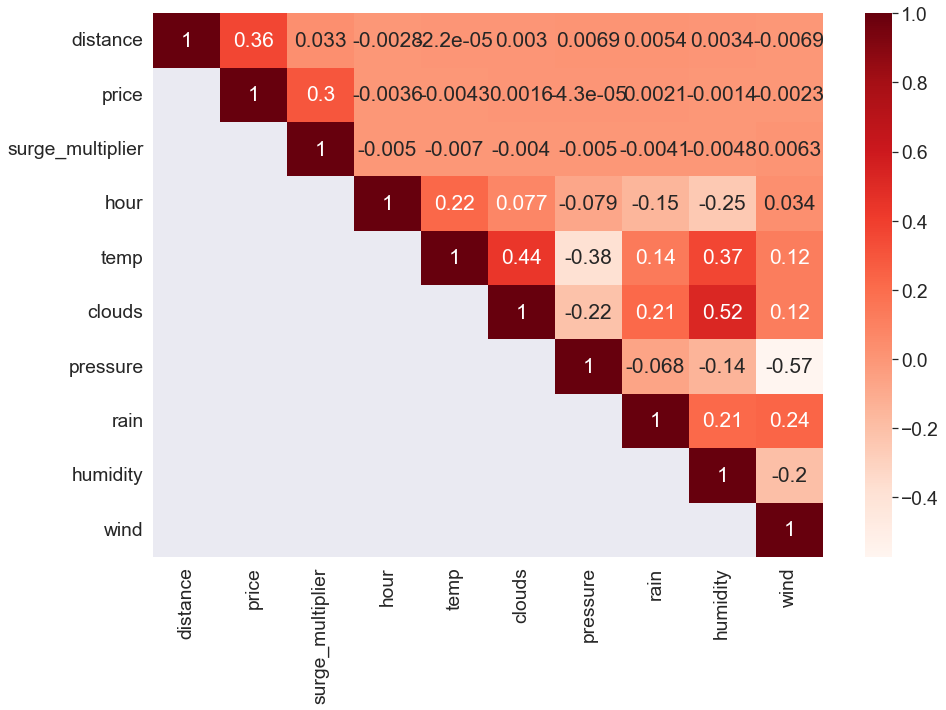

In [82]:
plt.figure(figsize=(15,10))
corr_m = lyft_data.corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [83]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance            0.363267
surge_multiplier    0.297555
temp                0.004257
hour                0.003613
wind                0.002307
rain                0.002115
clouds              0.001589
humidity            0.001391
pressure            0.000043
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind. (we can ignore surge multiplier, as it leaks info about price.)          
Rain and temperature are not significant.

**Uber**

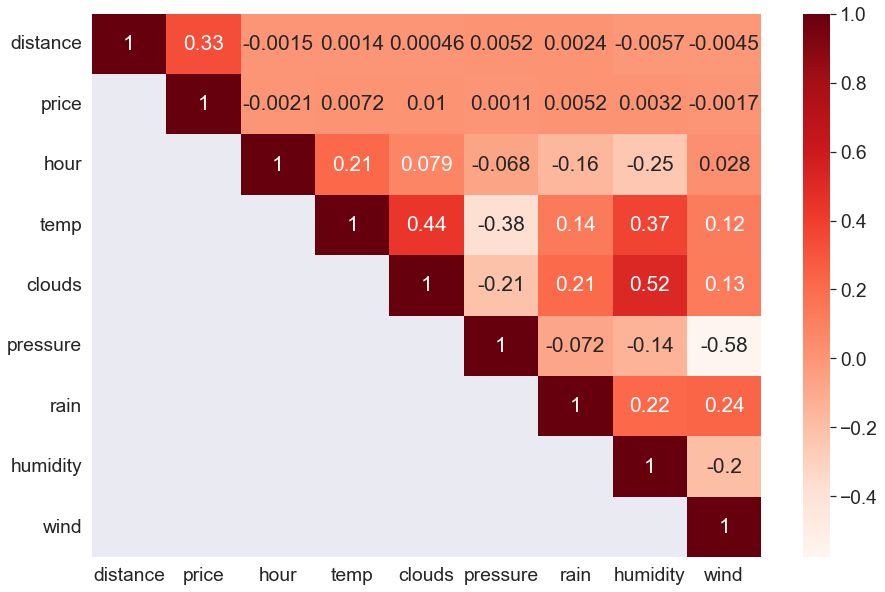

In [84]:
plt.figure(figsize=(15,10))
corr_m = uber_data[['distance', 'destination', 'source', 'price','name', 'hour', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind']].corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

In [85]:
corr_m['price'].abs().sort_values(ascending=False)[1:]

distance    0.333699
clouds      0.010198
temp        0.007182
rain        0.005173
humidity    0.003221
hour        0.002086
wind        0.001688
pressure    0.001132
Name: price, dtype: float64

From the correlation, we can see distance is moderately correlated,           
followed by pressure, hour and wind.          
Rain and clouds are not significant.

In [86]:
uber1_X = uber_X.copy()
uber1_y = uber_y.copy()

In [87]:
lyft1_X = lyft_X
lyft1_y = lyft_y

### 2. Lasso

In [88]:
from sklearn.linear_model import LassoCV

**Uber**

In [89]:
reg = LassoCV()
reg.fit(uber1_X, uber1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(uber1_X,uber1_y))
coef = pd.Series(reg.coef_, index = uber1_X.columns)
coef

Best alpha using built-in LassoCV: 0.003377
Best score using built-in LassoCV: 0.921948


distance                         2.504768
hour                            -0.000546
temp                            -0.000268
clouds                          -0.000000
pressure                        -0.000659
rain                            -0.000000
humidity                        -0.000000
wind                             0.002883
Black                            7.885201
Black SUV                       17.671348
UberPool                        -3.850517
UberX                           -2.789833
UberXL                           3.051175
WAV                             -2.807754
src_Back Bay                    -0.060591
src_Beacon Hill                 -0.272966
src_Boston University           -0.150171
src_Fenway                      -0.036632
src_Financial District           0.283971
src_Haymarket Square             0.384336
src_North End                    0.470304
src_North Station                0.000000
src_Northeastern University     -0.375442
src_South Station                0

In [90]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 30 variables and eliminated the other 8 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

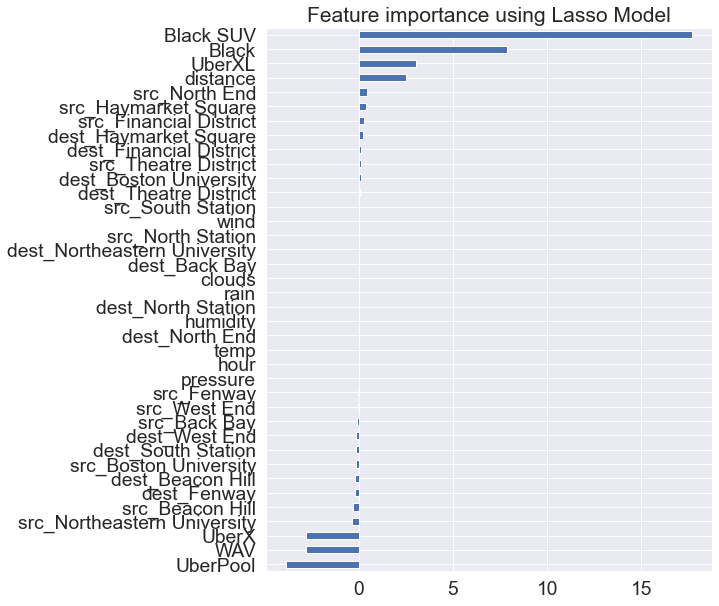

In [91]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

**Lyft**

In [92]:
reg = LassoCV()
reg.fit(lyft1_X, lyft1_y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(lyft1_X, lyft1_y))
coef = pd.Series(reg.coef_, index = lyft1_X.columns)
coef

Best alpha using built-in LassoCV: 0.003976
Best score using built-in LassoCV: 0.882281


distance                         3.438652
hour                             0.000032
temp                            -0.000000
clouds                          -0.023664
pressure                        -0.000557
rain                            -0.000000
humidity                        -0.000000
wind                             0.005580
Lux                              2.456462
Lux Black                        7.795966
Lux Black XL                    16.998328
Lyft                            -5.664502
Lyft XL                         -0.000000
Shared                          -9.218895
src_Back Bay                     0.698762
src_Beacon Hill                 -0.256695
src_Boston University           -0.405934
src_Fenway                       0.020629
src_Financial District           0.000000
src_Haymarket Square            -0.136817
src_North End                    0.000000
src_North Station               -0.433277
src_Northeastern University     -0.000000
src_South Station                0

In [93]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 31 variables and eliminated the other 7 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

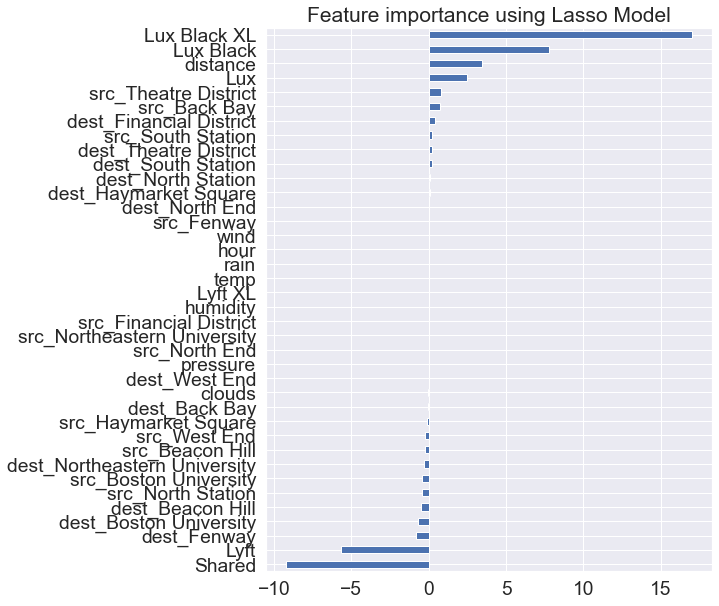

In [94]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### Feature transformation

#### Scaling

In [95]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

uber_std = pd.DataFrame(sc.fit_transform(uber_X[['distance', 'hour', 'pressure', 'rain']]), 
                        columns=['distance', 'hour', 'pressure', 'rain'])

lyft_std = pd.DataFrame(sc.fit_transform(lyft_X[['distance', 'hour', 'pressure', 'rain']]),
                        columns=['distance', 'hour', 'pressure', 'rain'])

uber_X = uber_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)
lyft_X = lyft_X.drop(['distance', 'hour', 'pressure', 'rain'], axis=1)

uber_X = pd.concat([uber_std, uber_X], axis=1)
lyft_X = pd.concat([lyft_std, lyft_X], axis=1)

### Model Building

In [96]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

### 1. Linear Regression

**Uber**

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_X, uber_y, test_size=0.3, random_state=42)

In [98]:
lin_reg_uber = LinearRegression()
lin_reg_uber.fit(X_trainu, y_trainu)

# print(f'Train score : {lin_reg_uber.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lin_reg_uber.predict(X_trainu)))}')
predicted = lin_reg_uber.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 2.384863579535003
Test score : 2.4184299656024266


In [99]:
train_cv = cross_val_score(LinearRegression(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_uber = {}
l_reg_uber['Train'] = round(train_rmse, 4)
l_reg_uber['Test'] = round(test_rmse, 4)
l_reg_uber

{'Train': 2.3871, 'Test': 2.4166}

In [100]:
# R squared for model
l_reg_uber['R2'] = r2_score(y_testu, predicted)
l_reg_uber['R2']

0.9209225155392478

**Lyft**

In [101]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_X, lyft_y, test_size=0.3, random_state=42)

In [102]:
lin_reg_lyft = LinearRegression()
lin_reg_lyft.fit(X_trainl, y_trainl)

# print(f'Train score : {lin_reg_lyft.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lin_reg_lyft.predict(X_trainl)))}')
predicted = lin_reg_lyft.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

Train RMSE score : 3.389476784827813
Test score : 3.55587747247622


In [103]:
train_cv = cross_val_score(LinearRegression(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(LinearRegression(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

l_reg_lyft = {}
l_reg_lyft['Train'] = round(train_rmse, 4)
l_reg_lyft['Test'] = round(test_rmse, 4)
l_reg_lyft

{'Train': 3.3921, 'Test': 3.5541}

In [104]:
# R squared for model
l_reg_lyft['R2'] = r2_score(y_testl, predicted)
l_reg_lyft['R2']

0.8756408127910058

### 2. Lasso

**Uber**

In [105]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainu, y_trainu)
lasso_reg_predict = lasso_reg.predict(X_testu)

# print(f'Train score : {lasso_reg.score(X_trainu, y_trainu)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu)))}')
predicted = lasso_reg.predict(X_testu)
# print(np.sqrt(mean_squared_error(y_trainu, lasso_reg.predict(X_trainu))))
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train RMSE score : 5.465000434218929
Test score : 5.48212210185929


In [106]:
train_cv = cross_val_score(Lasso(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_uber = {}
la_reg_uber['Train'] = round(train_rmse, 4)
la_reg_uber['Test'] = round(test_rmse, 4)
la_reg_uber

{'Train': 5.4657, 'Test': 5.4467}

In [107]:
# R squared for model
la_reg_uber['R2'] = r2_score(y_testu, predicted)
la_reg_uber['R2']

0.5936659440026155

**Hyperparameter Tuning**

In [108]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
#grid_search.fit(X_trainu,y_trainu)
#grid_search.best_estimator_

**Lyft**

In [109]:
lasso_reg = Lasso(random_state=42)
lasso_reg.fit(X_trainl, y_trainl)

# print(f'Train score : {lasso_reg.score(X_trainl, y_trainl)}')
print(f'Train RMSE score : {np.sqrt(mean_squared_error(y_trainl, lasso_reg.predict(X_trainl)))}')
predicted = lasso_reg.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(Lasso(random_state=42), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train RMSE score : 6.100627441091555
Test score : 6.251271642114056


In [110]:
train_cv = cross_val_score(Lasso(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(Lasso(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

la_reg_lyft = {}
la_reg_lyft['Train'] = round(train_rmse, 4)
la_reg_lyft['Test'] = round(test_rmse, 4)
la_reg_lyft

{'Train': 6.1014, 'Test': 6.1796}

In [111]:
# R squared for model
la_reg_lyft['R2'] = r2_score(y_testl, predicted)
la_reg_lyft['R2']

0.6156551717148668

**HyperParameter Tuning**

In [112]:
lambdas=np.linspace(1,100,100)
params={'alpha':lambdas}
grid_search=GridSearchCV(Lasso(),param_grid=params,cv=10,scoring='neg_mean_absolute_error')
#grid_search.fit(X_trainl,y_trainl)
#grid_search.best_estimator_

### 3. Decision Trees

**Uber**

In [113]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(uber_leX, uber_ley, test_size=0.3, random_state=42)

In [114]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 0.44924411340162
Test score : 2.7721430562660054


In [115]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainu, y_trainu)
    train_pred = dt.predict(X_trainu)
    rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testu)
    ts_rmse = np.sqrt(mean_squared_error(y_testu, y_pred))
    test_results.append(ts_rmse)

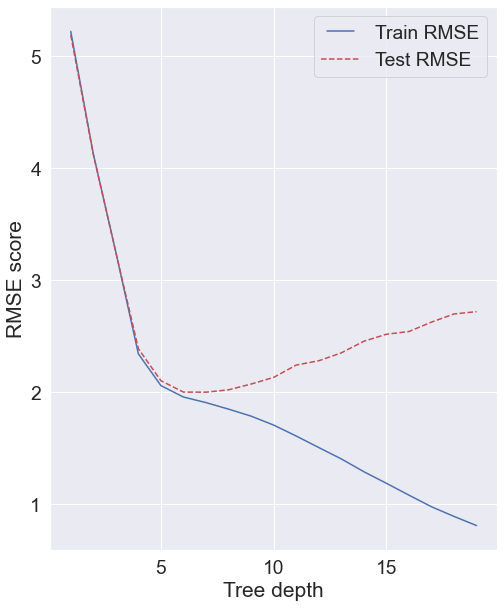

In [116]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

Let's choose 4 as max depth

In [121]:
dtree = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1)

Train score : 3.8567237541875152
Test score : 3.863311807754633


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [122]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_uber = {}
dt_reg_uber['Train'] = round(train_rmse, 4)
dt_reg_uber['Test'] = round(test_rmse, 4)
dt_reg_uber

{'Train': 2.7681, 'Test': 2.8019}

In [123]:
# R squared for model
dt_reg_uber['R2'] = r2_score(y_testu, predicted)
dt_reg_uber['R2']

0.7982073527572892

**HyperParameter tuning**

In [124]:
param_grid = {'max_depth': np.arange(3, 30),
             'min_samples_split': np.arange(.1,1.1,.1),
             'min_samples_leaf': np.arange(.1,.6,.1)}

In [125]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
#grid_srch_dtree.fit(X_trainu, y_trainu)
#grid_srch_dtree.best_estimator_

**Lyft**

In [126]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(lyft_leX, lyft_ley, test_size=0.3, random_state=42)

In [127]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainl, y_trainl)
    train_pred = dt.predict(X_trainl)
    rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testl)
    ts_rmse = np.sqrt(mean_squared_error(y_testl, y_pred))
    test_results.append(ts_rmse)

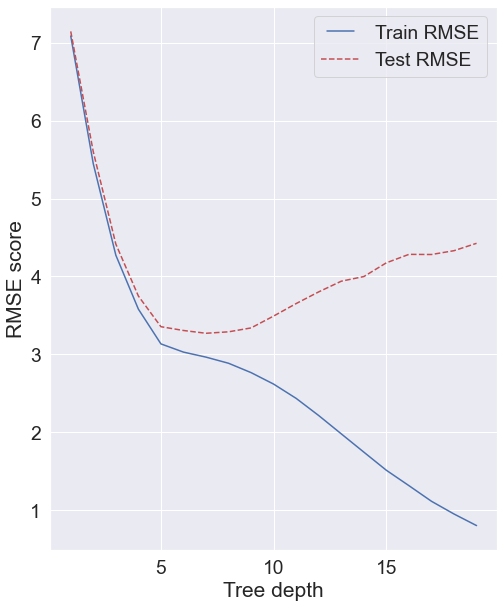

In [128]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depth, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depth, test_results, 'r--', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()

In [131]:
dtree = DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           random_state=None, splitter='best')

dtree.fit(X_trainl, y_trainl)

train_pred = dtree.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

# cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1)

Train score : 4.534015904360876
Test score : 4.664715245789472


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [132]:
train_cv = cross_val_score(DecisionTreeRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(DecisionTreeRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

dt_reg_lyft = {}
dt_reg_lyft['Train'] = round(train_rmse, 4)
dt_reg_lyft['Test'] = round(test_rmse, 4)
dt_reg_lyft

{'Train': 4.3904, 'Test': 4.6144}

In [133]:
# R squared for model
dt_reg_lyft['R2'] = r2_score(y_testl, predicted)
dt_reg_lyft['R2']

0.7859897497727031

**HyperParameter tuning**

In [134]:
grid_srch_dtree = tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10,scoring='neg_mean_squared_error')
#grid_srch_dtree.fit(X_trainl, y_trainl)
#grid_srch_dtree.best_estimator_

### 4. Random Forest

In [135]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.cross

In [137]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

rf.fit(X_trainu, y_trainu)

train_pred = rf.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Train score : 1.2487440966649073
Test score : 1.9997349234567317
[2.07092578 2.05713184 2.03737729 1.99417038 2.07341231]


In [138]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_uber = {}
rf_reg_uber['Train'] = round(train_rmse, 4)
rf_reg_uber['Test'] = round(test_rmse, 4)
rf_reg_uber

{'Train': 2.0484, 'Test': 2.0906}

In [139]:
# R squared for model
rf_reg_uber['R2'] = r2_score(y_testu, predicted)
rf_reg_uber['R2']

0.9459331986218507

**Hyper Parameter Tuning**

In [140]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 6, 8, 10, 11, 13, 15, 16, 18, 20, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [141]:
X_trainl.shape

(33695, 11)

In [142]:
# Random search of parameters, using 10 fold cross validation, 
# search across 10000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_trainu, y_trainu)

In [143]:
#rf_random.best_estimator_

**Lyft data**

In [145]:
rf = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf.fit(X_trainl, y_trainl)

train_pred = rf.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = rf.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Train score : 1.5051901302313806
Test score : 3.2593843248733085
[3.2322782  3.09872817 3.20270861 3.18200893 3.28606401]


In [146]:
train_cv = cross_val_score(RandomForestRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(RandomForestRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

rf_reg_lyft = {}
rf_reg_lyft['Train'] = round(train_rmse, 4)
rf_reg_lyft['Test'] = round(test_rmse, 4)
rf_reg_lyft

{'Train': 3.2014, 'Test': 3.3658}

In [147]:
# R squared for model
rf_reg_lyft['R2'] = r2_score(y_testl, predicted)
rf_reg_lyft['R2']

0.8955146397108834

**Hyper Parameter Tuning**

In [148]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 6, 8, 10, 11, 13, 15, 16, 18, 20, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [149]:
X_trainl.shape

(33695, 11)

In [150]:
# Random search of parameters, using 10 fold cross validation, 
# search across 10000 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_trainl, y_trainl)

In [151]:
#rf_random.best_estimator_

### 5. Boosting - Ada Boost

In [152]:
from sklearn.ensemble import AdaBoostRegressor

In [153]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainu, y_trainu)

train_pred = abr.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.16068585679679
Test score : 5.200564622870834
[4.7954471  5.03851914 5.06077905 5.64313185 5.5392045 ]


In [154]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainu, y_trainu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testu, y_testu, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_uber = {}
abr_reg_uber['Train'] = round(train_rmse, 4)
abr_reg_uber['Test'] = round(test_rmse, 4)
abr_reg_uber

{'Train': 5.0724, 'Test': 4.7601}

In [155]:
# R squared for model
abr_reg_uber['R2'] = r2_score(y_testu, predicted)
abr_reg_uber['R2']

0.6343321237046448

In [156]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(X_trainl, y_trainl)

train_pred = abr.predict(X_trainl)

tr_rmse = np.sqrt(mean_squared_error(y_trainl, train_pred))
print(f'Train score : {tr_rmse}')
predicted = abr.predict(X_testl)
rmse = np.sqrt(mean_squared_error(y_testl, predicted))
print(f'Test score : {rmse}')

cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print(np.sqrt(np.abs(cv)))

Train score : 5.359329321469561
Test score : 5.426141510370088
[5.79783242 5.5108359  5.01276775 5.37797632 4.97489523]


In [157]:
train_cv = cross_val_score(AdaBoostRegressor(), X_trainl, y_trainl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
train_rmse = np.sqrt(np.abs(train_cv)).mean()

test_cv = cross_val_score(AdaBoostRegressor(), X_testl, y_testl, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
test_rmse = np.sqrt(np.abs(test_cv)).mean()

abr_reg_lyft = {}
abr_reg_lyft['Train'] = round(train_rmse, 4)
abr_reg_lyft['Test'] = round(test_rmse, 4)
abr_reg_lyft

{'Train': 5.1891, 'Test': 5.2777}

In [158]:
# R squared for model
abr_reg_lyft['R2'] = r2_score(y_testl, predicted)
abr_reg_lyft['R2']

0.7104213555419986

## Executive Summary
Prices for cabs are not constant like public transport. They are greatly affected by the demand and supply of rides at a given time. So what exactly drives this demand? The first guess would be the time of the day; times around 9 am and 5 pm should see the highest surges on account of people commuting to work/home. Another guess would be the weather; rain/snow should cause more people to take rides.

For our analysis we will limit the number of rows to 0.1M out of a total of 0.693M. We performed our analysis on this dataset obtained from kaggle and found that there are 2 major cab aggregators operating in the Boston area, namely Lyft and Uber. Uber has approximately 51.8 percent market share and Lyft has approximately 48.2 percent. Additionally, Uber is cheaper on average with more number of sporadically high prices. It was also observed that price is positively correlated to distance and temperature but negatively correlated to weather conditions like wind and rain. Uber does not shows the surge multipier and directly displays the increased price where as Lyft displays price along with the surge multiplier. 

For model building we randomly split our data in 70% training set and 30% testing set. We further built various regression models like Linear Regression, Lasso Regression,Decision Tree, Random Forest, Ada Boost on the dataset and found that most of the models did give us high accuracy with random forest being the best with lowerst RMSE value of 1.76 and 3.14 for Uber and Lyft data respectively and maximum R2 value .969 and .931 for Uber and Lyft data respectively for the testing dataset.
#### From our indepth analysis for both Lyft and Uber data we can conclude that Random forest is the best method for our price prediction.

**Uber results**

In [159]:
final_results = pd.DataFrame([l_reg_uber, la_reg_uber, dt_reg_uber,
                              rf_reg_uber, abr_reg_uber],
                            index=['Linear Regression', 'Lasso Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost'])
final_results

,Train,Test,R2
Linear Regression,2.3871,2.4166,0.920923
Lasso Regression,5.4657,5.4467,0.593666
Decision Tree,2.7681,2.8019,0.798207
Random Forest,2.0484,2.0906,0.945933
Ada Boost,5.0724,4.7601,0.634332


**Lyft results**

In [160]:
final_results = pd.DataFrame([l_reg_lyft, la_reg_lyft, dt_reg_lyft,
                              rf_reg_lyft, abr_reg_lyft],
                            index=['Linear Regression', 'Lasso Regression',
                                  'Decision Tree', 'Random Forest', 'Ada Boost'])
final_results

,Train,Test,R2
Linear Regression,3.3921,3.5541,0.875641
Lasso Regression,6.1014,6.1796,0.615655
Decision Tree,4.3904,4.6144,0.785990
Random Forest,3.2014,3.3658,0.895515
Ada Boost,5.1891,5.2777,0.710421
